In [1]:
#Core Python, Pandas, and kaldi_io
import numpy as np
import pandas as pd
import string
from collections import Counter
import kaldi_io

#Scikit
from sklearn import manifold
from sklearn.model_selection import train_test_split
from sklearn.neighbors import NearestNeighbors
from sklearn.metrics import pairwise_distances,average_precision_score
from sklearn.metrics.pairwise import pairwise_kernels
from scipy import stats

#Plotting
from matplotlib import pyplot as plt
import seaborn as sns
from scipy.spatial.distance import pdist


#Torch and utilities
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import TensorDataset,DataLoader,random_split,ConcatDataset

from data_helpers import DataHelper

################################################################################
### WARNING, path does not exist: KALDI_ROOT=/mnt/matylda5/iveselyk/Tools/kaldi-trunk
###          (please add 'export KALDI_ROOT=<your_path>' in your $HOME/.profile)
###          (or run as: KALDI_ROOT=<your_path> python <your_script>.py)
################################################################################



Stats of the MuliView Trainset

In [2]:
filepath = "Data/multi_view/trainset.list"

In [3]:
count = 0
words = []
with open(filepath) as fp:
    lines = fp.readlines()
    for line in lines: 
        count += 1
        #print("Line{}: {}".format(count, line.strip()))
        word = line.strip().split("_")[0]
        #print(word)
        words.append(word)

In [4]:
w = Counter(words)

In [5]:
print("Number of Examples {}".format(len(words)))
print("Number of Unique Words {}".format(len(w.keys())))
print("Maximum frequency {}".format(max(w.values())))
print("Minimum frequency {}".format(min(w.values())))
print("Maximum Character Length {}".format(max(list(map(len,w.keys())))))
print("Minimum Character Length {}".format(min(list(map(len,w.keys())))))

Number of Examples 9971
Number of Unique Words 1687
Maximum frequency 149
Minimum frequency 2
Maximum Character Length 18
Minimum Character Length 4


In [6]:
w.most_common()

[('recycling', 149),
 ('benefits', 136),
 ('because', 98),
 ('insurance', 93),
 ('punishment', 80),
 ('recycle', 78),
 ('company', 66),
 ('exactly', 65),
 ('people', 60),
 ('really', 59),
 ('probably', 59),
 ('newspapers', 57),
 ('plastic', 57),
 ('expensive', 56),
 ('something', 56),
 ('everything', 56),
 ('things', 55),
 ('problem', 54),
 ('situation', 50),
 ('important', 45),
 ('problems', 43),
 ('companies', 42),
 ('testing', 41),
 ('interesting', 40),
 ('vacation', 39),
 ('understand', 39),
 ('retirement', 39),
 ('somebody', 37),
 ('actually', 36),
 ('definitely', 36),
 ('myself', 35),
 ('recycled', 35),
 ('especially', 34),
 ('anything', 34),
 ('person', 33),
 ('absolutely', 33),
 ('expenses', 33),
 ('positive', 33),
 ('system', 33),
 ('security', 32),
 ('program', 32),
 ("that's", 31),
 ('alcohol', 31),
 ('college', 31),
 ('aluminum', 30),
 ('everybody', 30),
 ('employees', 30),
 ('plastics', 29),
 ('bottles', 29),
 ('before', 28),
 ('dollars', 27),
 ('sometimes', 27),
 ('basica

In [7]:
w_c = Counter(w.values())
w_c.most_common()

[(2, 626),
 (3, 329),
 (4, 187),
 (5, 124),
 (6, 88),
 (8, 50),
 (7, 46),
 (9, 40),
 (11, 26),
 (12, 18),
 (10, 16),
 (14, 14),
 (13, 8),
 (20, 7),
 (17, 7),
 (21, 7),
 (16, 7),
 (24, 6),
 (33, 5),
 (26, 5),
 (15, 5),
 (23, 5),
 (22, 4),
 (25, 4),
 (39, 3),
 (56, 3),
 (30, 3),
 (31, 3),
 (18, 3),
 (19, 3),
 (29, 2),
 (59, 2),
 (34, 2),
 (57, 2),
 (32, 2),
 (36, 2),
 (35, 2),
 (27, 2),
 (80, 1),
 (98, 1),
 (149, 1),
 (93, 1),
 (66, 1),
 (136, 1),
 (65, 1),
 (55, 1),
 (37, 1),
 (78, 1),
 (60, 1),
 (28, 1),
 (50, 1),
 (41, 1),
 (54, 1),
 (43, 1),
 (42, 1),
 (45, 1),
 (40, 1)]

(array([1584.,   62.,   22.,   11.,    2.,    2.,    2.,    0.,    0.,
           2.]),
 array([  2. ,  16.7,  31.4,  46.1,  60.8,  75.5,  90.2, 104.9, 119.6,
        134.3, 149. ]),
 <a list of 10 Patch objects>)

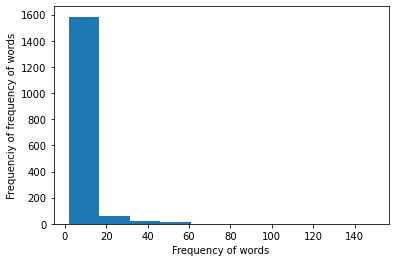

In [8]:
plt.ylabel("Frequenciy of frequency of words")
plt.xlabel("Frequency of words")
plt.hist(w.values())

Stats of AMI Dataset

In [31]:
load_list = ['Data/feats_cmvn.ark']
num_examples = np.Inf
dh = DataHelper(load_list,num_examples)
dh.load_data(char_threshold = 4, frequency_bounds = (0,np.Inf))
dh.process_data()
c,word_to_num,num_to_word = dh.generate_key_dicts()

inputs,labels = dh.give_inputs_and_labels()

Length before filtering on char length 317927
Length after filtering on char length 244494
Length before filtering on frequency_bounds 244494
Length after filtering on frequency_bounds 244494
Finished Loading the Data, 244494 examples
Number of Unique words  11177


In [32]:
c = Counter(dh.keys)

In [33]:
c = Counter(dh.keys)
print("Number of Examples {}".format(len(dh.keys)))
print("Number of Unique Words {}".format(len(c.keys())))
print("Maximum frequency {}".format(max(c.values())))
print("Minimum frequency {}".format(min(c.values())))
print("Maximum Character Length {}".format(max(list(map(len,c.keys())))))
print("Minimum Character Length {}".format(min(list(map(len,c.keys())))))

Number of Examples 244494
Number of Unique Words 11177
Maximum frequency 2946
Minimum frequency 1
Maximum Character Length 20
Minimum Character Length 4


In [34]:
c.most_common()

[('yeah', 2946),
 ('okay', 2359),
 ('well', 2148),
 ('just', 1802),
 ('thats', 1682),
 ('right', 1673),
 ('that', 1546),
 ('like', 1519),
 ('think', 1378),
 ('because', 1329),
 ('maybe', 1271),
 ('mmhmm', 1264),
 ('something', 1205),
 ('this', 1184),
 ('have', 1156),
 ('then', 1105),
 ('about', 1088),
 ('remote', 1081),
 ('what', 1045),
 ('know', 987),
 ('buttons', 967),
 ('dont', 950),
 ('control', 913),
 ('really', 885),
 ('also', 882),
 ('some', 880),
 ('very', 877),
 ('with', 861),
 ('actually', 839),
 ('more', 826),
 ('should', 825),
 ('thing', 821),
 ('people', 816),
 ('button', 809),
 ('things', 788),
 ('here', 782),
 ('want', 769),
 ('there', 765),
 ('design', 745),
 ('different', 744),
 ('make', 741),
 ('probably', 729),
 ('time', 706),
 ('mean', 704),
 ('five', 664),
 ('which', 664),
 ('meeting', 658),
 ('good', 648),
 ('could', 632),
 ('alright', 622),
 ('kind', 620),
 ('screen', 618),
 ('from', 613),
 ('three', 598),
 ('next', 584),
 ('idea', 579),
 ('much', 562),
 ('would'

In [35]:
f_c = Counter(c.values())
f_c.most_common()

[(1, 4398),
 (2, 1552),
 (3, 872),
 (4, 542),
 (5, 377),
 (6, 318),
 (7, 233),
 (8, 215),
 (9, 160),
 (10, 138),
 (11, 119),
 (12, 102),
 (13, 88),
 (14, 86),
 (17, 71),
 (15, 70),
 (16, 66),
 (19, 58),
 (22, 55),
 (18, 50),
 (20, 49),
 (21, 49),
 (24, 48),
 (26, 44),
 (25, 36),
 (23, 36),
 (29, 34),
 (27, 34),
 (28, 31),
 (31, 28),
 (35, 26),
 (32, 25),
 (33, 24),
 (36, 24),
 (48, 22),
 (34, 22),
 (30, 21),
 (44, 19),
 (38, 19),
 (51, 18),
 (43, 18),
 (41, 18),
 (42, 18),
 (46, 15),
 (47, 15),
 (40, 15),
 (45, 15),
 (39, 15),
 (57, 14),
 (54, 14),
 (37, 14),
 (73, 13),
 (61, 11),
 (56, 11),
 (50, 11),
 (70, 10),
 (60, 10),
 (55, 9),
 (74, 9),
 (59, 9),
 (72, 9),
 (58, 9),
 (97, 8),
 (63, 8),
 (82, 8),
 (71, 8),
 (66, 8),
 (52, 8),
 (80, 7),
 (69, 7),
 (86, 7),
 (67, 7),
 (90, 7),
 (53, 7),
 (108, 7),
 (79, 7),
 (88, 7),
 (62, 7),
 (81, 6),
 (78, 6),
 (65, 6),
 (109, 6),
 (101, 6),
 (102, 6),
 (64, 6),
 (137, 5),
 (121, 5),
 (126, 5),
 (91, 5),
 (147, 5),
 (141, 5),
 (115, 5),
 (159, 5

In [36]:
x = list(c.values())

y = [e for e in x if e >= 155]

print(len(y))

357


(array([9200.,  731.,  306.,  181.,  122.,   80.,   60.,   46.,   44.,
          46.]),
 array([  0.,  15.,  30.,  45.,  60.,  75.,  90., 105., 120., 135., 150.]),
 <a list of 10 Patch objects>)

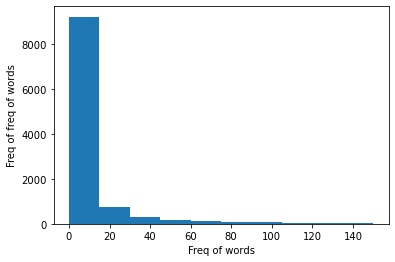

In [37]:
plt.xlabel("Freq of words")
plt.ylabel("Freq of freq of words")
plt.hist(c.values(),range = (0,150))

In [21]:
x_set = set(w.keys())
y_set = set(c.keys())

print(len(x_set.intersection(y_set)))

1772


Rough
